In [1]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import random
import matplotlib.pyplot as plt
import numpy as np
USE_CUDA = torch.cuda.is_available() 
device = torch.device("cuda" if USE_CUDA else "cpu") 
print("device", device)
batch_size = 18
hidden_size = 10
input_size = 2
output_size = 1

class Custom_Activation_F:
    
    def __init__(self, rate = 1):
        self.rate = rate
        
    def logact(self, a):
        '''
        logistic activation function
        '''
        i = 0
        while i < len(a):
            j = 0
            while j < len(a[i]):
                if a[i][j] > 0:
                    a[i][j] = torch.log(a[i][j] + self.rate)
                else:
                    a[i][j] = - torch.log(self.rate - a[i][j])
                j = j + 1
            i = i + 1
        return a
    


device cpu


In [10]:
class bnn(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.batch_size = 1
        self.tanh = nn.Tanh()
        self.lrelu = nn.LeakyReLU(0.1)
        self.myact = Custom_Activation_F()
        self.w1 = nn.Parameter(
            torch.zeros(input_size, self.hidden_size, dtype = torch.float32, requires_grad=True)
        )
        self.b = nn.Parameter(
            torch.zeros(self.hidden_size, dtype = torch.float32,requires_grad=True)
        )
        self.w2 = nn.Parameter(
            torch.zeros(self.hidden_size, output_size, dtype = torch.float32, requires_grad=True)
        )
        
        self.w1_prior = torch.zeros(input_size, hidden_size)
        self.b_prior = torch.zeros(hidden_size)
        self.w2_prior = torch.zeros(hidden_size, output_size)
        
    def _rep(self, mu):
        return mu + torch.randn_like(mu)*0.1
    
    def _update_prior(self, w1, w2, b, rate = 0.1):
        self.w1_prior = w1.clone().detach()*rate + self.w1_prior*(1-rate)
        self.w2_prior = w2.clone().detach()*rate + self.w2_prior*(1-rate)
        self.b_prior = b.clone().detach()*rate + self.b_prior*(1-rate)
        
    def _kldloss(self):
        sum1 = torch.sum(torch.square(self.w1 - self.w1_prior))
        sum2 = torch.sum(torch.square(self.w2 - self.w2_prior))
        sum3 = torch.sum(torch.square(self.b - self.b_prior))
        return sum1 + sum2 + sum3
    
    def forward(self, x, batch_size, rate):
        self.batch_size = batch_size
        b = self._rep(self.b)
        w1 = self._rep(self.w1)
        w2 = self._rep(self.w2)
        b = b.expand(self.batch_size, self.hidden_size)
        x = torch.matmul(x, w1) + b
        x = self.myact.logact(x)
        x = torch.matmul(x, w2)
        self._update_prior(self.w1_prior, self.w2_prior, self.b_prior, rate)
        #if we want to move prior, we can just subtract _prior term at the upper line
        return x
    
    def bayesian_loss(self, target, output, data_num):
        
        likelihood = torch.sum(torch.square(target - output))
        return likelihood + (self.batch_size/data_num) * self._kldloss()
        


In [11]:
tmp_data = torch.tensor([[-1., 3., 5], [-2, 2, 5], [-0.5, 2, 4], 
                         [-0.5, 1.5, 3], [0.5, 1, 1], [1, 1, -1],
                         [2, 2, -3], [3, 2, -4], [4, 4, -5],
                         [5, 4, -4], [5, 5, -3], [6, 4, -2],
                         [7, 4, -1], [8, 3, 0], [8, 4, 1],
                         [9, 3, 3], [9, 1, 5], [10, 2, 6]])



#we have to save posterior to prior w1, w2, b

In [12]:
mybnn = bnn(input_size, hidden_size, output_size)
train_dataloader = DataLoader(tmp_data, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.SGD(mybnn.parameters(), lr=0.001)


In [19]:
i = 0
while i < 100:
    train_data = next(iter(train_dataloader))
    input_data, target = torch.split(train_data, [input_size, output_size], dim = 1)
    output = mybnn(input_data, batch_size, rate = 0.01)
    loss = mybnn.bayesian_loss(target, output,data_num = 18)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(loss)
    i = i + 1

tensor(134.6526, grad_fn=<AddBackward0>)


C:\Users\sppo\AppData\Local\Temp\ipykernel_11080\649124158.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z9 = torch.tensor(z, requires_grad = False).numpy()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


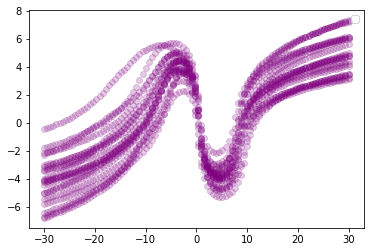

In [20]:
x = np.linspace(-30, 30, 100)
y = np.linspace(4, 4, 100)
newxy = np.concatenate((np.transpose([x]), np.transpose([y])), axis = 1)
newxy = torch.tensor(newxy, dtype = torch.float32)
newxy = torch.reshape(newxy,(100,2))


i = 0
while i<20:
    z = mybnn(newxy,100,0.01)
    Z9 = torch.tensor(z, requires_grad = False).numpy()
    plt.scatter(x, Z9, color = 'purple', alpha = 0.2)
    i = i + 1

plt.legend()
plt.show()